<div style="float: right; width: 70%; height: 150px;">
  <div style="position: relative; top: 20%;padding-right:20%;">
  <div style="font-size:280%;font-weight: bold;padding-top: 20px;"> Exercise</div>
  <div style="font-size:180%;font-weight: bold;padding-top: 20px;color: rgba(0 , 0 , 0 , 0.5);"> Body waves</div>
  </div>
</div>


This script will get an event from IRIS and retrieve a seismogram for a selected station. It then converts the raw trace to ground displacement and computes body wave arrivals. Last, it tries to find a PKiKP phase.<br>

**Questions**:<br> 
**What is the traveltime difference between the P-wave and S-wave arrival?**<br>
**How far away is the epicenter of the event given a rule-of-thumb using this traveltime difference?**<br> 
**How do we find a PKiKP phase?**

for more notebooks in seismology, see:<br>
https://krischer.github.io/seismo_live_build/tree/index.html

## 0. Setup

Note: this python script requires extra packages for
    - matplotlib (version 2.1.2) : > pip install -U matplotlib
    - numpy      (version 1.14.0): > pip install -U numpy
    - obspy      (version 1.1.0) : > pip install -U obspy

In [61]:
from __future__ import print_function
import os,sys

# for fixed plots
%matplotlib inline
# for interactive plots
#%matplotlib notebook

import matplotlib as mpl
print("matplotlib version: ",mpl.__version__)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20, 5
plt.rcParams['lines.linewidth'] = 0.5

## numpy
import numpy as np
print("numpy version: ",np.__version__)

# do not show scipy warnings
import warnings
warnings.filterwarnings('ignore')

matplotlib version:  3.1.3
numpy version:  1.18.1


uses obspy<br>
http://docs.obspy.org<br>
a python framework for seismology


In [62]:
import obspy
print("obspy version: ",obspy.__version__)


obspy version:  1.1.1




## 1. Event information

Let's look at the 2011 Virginia quake.<br>

wikipedia: [2011 Virginia earthquake](https://en.wikipedia.org/wiki/2011_Virginia_earthquake)<br>
video footage from inside the Washington Monument: [youtube Washington Monument](https://www.youtube.com/watch?v=PRiOlPPcIPo)<br>
global CMT: [virginia event](https://www.globalcmt.org/cgi-bin/globalcmt-cgi-bin/CMT5/form?itype=ymd&yr=2011&mo=8&day=23&oyr=1976&omo=1&oday=1&jyr=1976&jday=1&ojyr=1976&ojday=1&otype=nd&nday=1&lmw=5.5&umw=6&lms=0&ums=10&lmb=0&umb=10&llat=-90&ulat=90&llon=-180&ulon=180&lhd=0&uhd=1000&lts=-9999&uts=9999&lpe1=0&upe1=90&lpe2=0&upe2=90&list=4)<br>


Specify the event time.<br>

Virginia quake: (Magnitude Mw ~ 5.8)<br>
August 23, 2011, UTC17:51:07.3 -> 2011-08-23T17:51:07.3
GlobalCMT: Event ID 201108231751A



In [63]:
print("getting event information...")
from obspy.clients.fdsn import Client

event_time = obspy.UTCDateTime("2011-08-23T17:51:07.30")

# data client
# data centers: FDSN, IRIS, ORFEUS, IPGP, ETH, GFZ, RESIF, GEONET, USGS, ..
c = Client("IRIS")  # no focal mechanism info for Virginia
#client = Client("USGS")   # no focal mechanism info for Virginia
#client = Client("ISC") # no focal mechanism info for Virginia

starttime = event_time - 10 * 60
endtime = event_time + 10 * 60
Mw_min = 5.0

catalog = c.get_events(starttime=starttime, endtime=endtime, minmagnitude=Mw_min)
# or
#catalog = c.get_events(eventid=3320897)
print("Event catalog:")
print(catalog)


getting event information...
Event catalog:
1 Event(s) in Catalog:
2011-08-23T17:51:03.600000Z | +37.919,  -78.040 | 5.7 MW


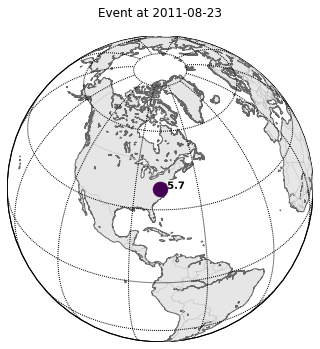

In [64]:
catalog.plot("ortho");

In [65]:
# select virginia event
event = catalog[0]
print("Event:")
print(event.short_str())

print("Event info:")
origin = event.preferred_origin()
#print(origin)

t0 = origin.time
lat = origin.latitude
lon = origin.longitude
dep = origin.depth

print("  time   : ",t0)
print("  lat/lon: ",lat,"/",lon,"(degree)")
print("  depth  : ",dep,"(m)")

# magnitude
magnitude = event.preferred_magnitude()
if magnitude == None:
    M = 0.0
    M_type = "no magnitude information available"
else:
    M = magnitude.mag
    M_type = magnitude.magnitude_type
print("  magnitude: ",M,"type ",M_type)

# moment magnitude
if M_type == 'MW':
    Mw = M
else:
    Mw = 0.0
    
# seismic moment based on moment magnitude (Kanamori, 1977): Mw = 2/3 log(M0) - 10.7 
M0 = 10**(3/2 * (Mw + 10.7))  # in dyne cm
# converts to (N m)
M0 = M0 * 1.e-7

print("")
print("Moment magnitude: ",Mw)
print("Seismic Moment  : ",M0,"(N m)")
print("")


Event:
2011-08-23T17:51:03.600000Z | +37.919,  -78.040 | 5.7 MW
Event info:
  time   :  2011-08-23T17:51:03.600000Z
  lat/lon:  37.919 / -78.0396 (degree)
  depth  :  7700.0 (m)
  magnitude:  5.7 type  MW

Moment magnitude:  5.7
Seismic Moment  :  3.981071705534953e+17 (N m)



## 2. Station information

Let's get some information about which stations would have waveform data

In [66]:
print("getting station information...")

# gets station informations
t1 = event_time
t2 = t1 + 10 * 60

# Global network stations (naming starts with A***)
inventory = c.get_stations(network="IU", station="A*",
                                starttime=t1,endtime=t2)
print(inventory)



getting station information...
Inventory created at 2020-02-27T06:24:57.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.44
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2011-08-23...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			IU
		Stations (4):
			IU.ADK (Adak, Aleutian Islands, Alaska)
			IU.AFI (Afiamalu, Samoa)
			IU.ANMO (Albuquerque, New Mexico, USA)
			IU.ANTO (Ankara, Turkey)
		Channels (0):



We will look at station ANMO (Albuquerque, US) from the global seismograph network:<br>
https://www.fdsn.org/networks/detail/IU/ <br>
https://www.fdsn.org/station_book/IU/ANMO/anmo.html <br>

In [67]:
print("inventory: ",len(inventory))
# network
network = inventory[0]
print(network)

# ANMO is 3. station in the list
station = network[2]
print(station)


inventory:  1
Network IU (Global Seismograph Network - IRIS/USGS (GSN))
	Station Count: 4/270 (Selected/Total)
	1988-01-01T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (4):
			IU.ADK (Adak, Aleutian Islands, Alaska)
			IU.AFI (Afiamalu, Samoa)
			IU.ANMO (Albuquerque, New Mexico, USA)
			IU.ANTO (Ankara, Turkey)
		Channels (0):

Station ANMO (Albuquerque, New Mexico, USA)
	Station Code: ANMO
	Channel Count: 0/239 (Selected/Total)
	2008-06-30T20:00:00.000000Z - 
	Access: open 
	Latitude: 34.95, Longitude: -106.46, Elevation: 1820.0 m
	Available Channels:



In [68]:
# seismograms
print("getting waveform...")

# Stations
# station: ANMO (Albuquerque, New Mexico, USA), broadband channel
net = "IU"
sta = "ANMO"
cha = "BH*"
loc = "00" 

# time window
tshift_begin = 0 # 0 min earlier
tshift_end = 20 * 60 # 20 min after
t1 = t0 + tshift_begin             
t2 = t0 + tshift_end

# dowloads seismogram as a stream
st = c.get_waveforms(network=net, station=sta, location=loc, channel=cha,
                     starttime=t1,endtime=t2, attach_response=True)
print(st)
print("")


getting waveform...
3 Trace(s) in Stream:
IU.ANMO.00.BH1 | 2011-08-23T17:51:03.619538Z - 2011-08-23T18:11:03.569538Z | 20.0 Hz, 24000 samples
IU.ANMO.00.BH2 | 2011-08-23T17:51:03.619538Z - 2011-08-23T18:11:03.569538Z | 20.0 Hz, 24000 samples
IU.ANMO.00.BHZ | 2011-08-23T17:51:03.619538Z - 2011-08-23T18:11:03.569538Z | 20.0 Hz, 24000 samples



In [69]:
# trace statistics
tr = st[0]
#print(tr.stats)
npts = tr.stats.npts      # number of samples
dt = tr.stats.delta       # time step
duration = npts * dt

freq_Ny = 1.0/(2.0 * dt)  # Nyquist frequency
freq_min = 1./duration    # minimal possible frequency for length of trace

print("trace:")
print("  duration = ",duration,"s"," = ",duration/60.,"min"," = ",duration/60./60.,"h")
print("  Nyquist frequency = ",freq_Ny)
print("  minimum frequency = ",freq_min)
print("")


trace:
  duration =  1200.0 s  =  20.0 min  =  0.3333333333333333 h
  Nyquist frequency =  10.0
  minimum frequency =  0.0008333333333333334



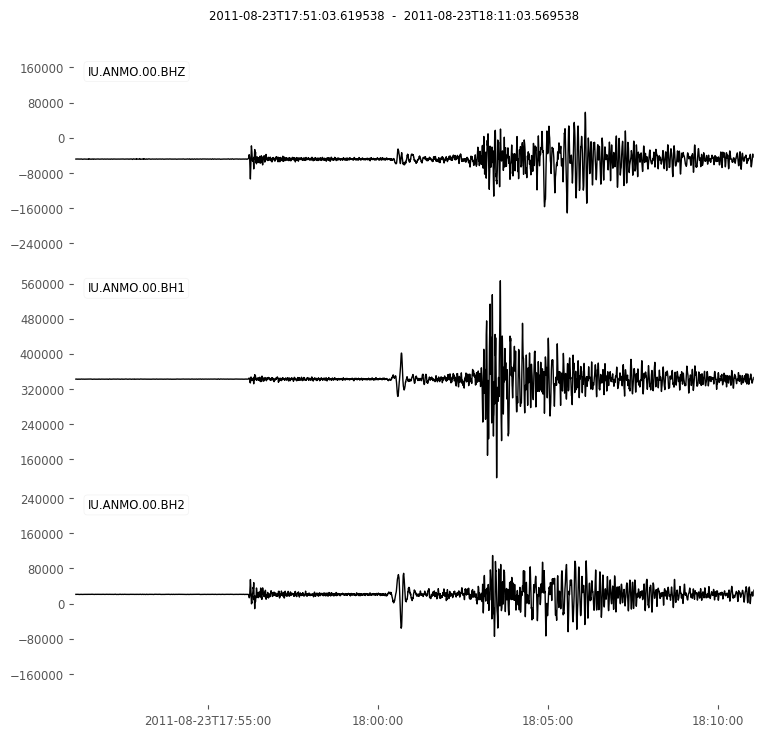

In [70]:
# plotting traces
st.plot();


IU.ANMO.00.BHZ | 2011-08-23T17:51:03.619538Z - 2011-08-23T18:11:03.569538Z | 20.0 Hz, 24000 samples


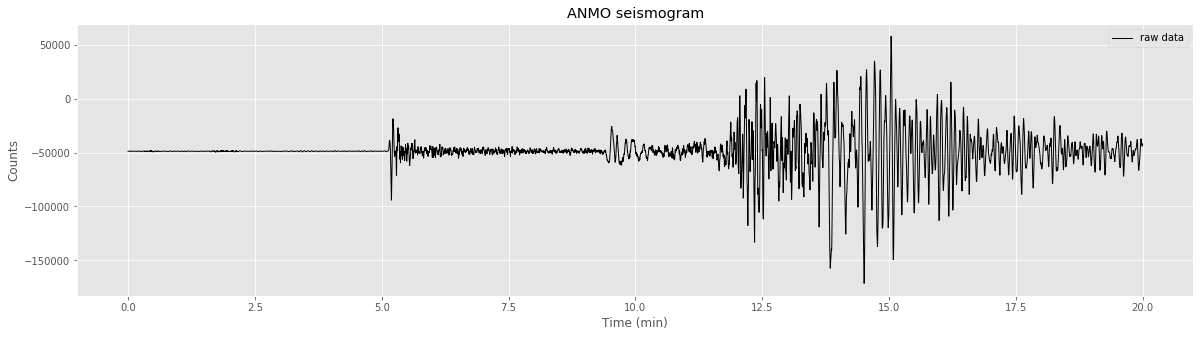

In [71]:
# time axis for plotting (in min)
t_d = np.linspace(0,duration,npts) / (60.0)  
# shift time scale to have 0 at event origin time
t_d += tshift_begin / 60.0

# vertical trace
print(st[2])

# plotting
plt.title("ANMO seismogram")
# vertical component
plt.plot(t_d, st[2].data, color='black', linewidth=1.0,label="raw data")
plt.legend()
plt.xlabel("Time (min)")
plt.ylabel("Counts")
plt.show()


## 2. Data processing

Detrending, tapering

processing waveform data...


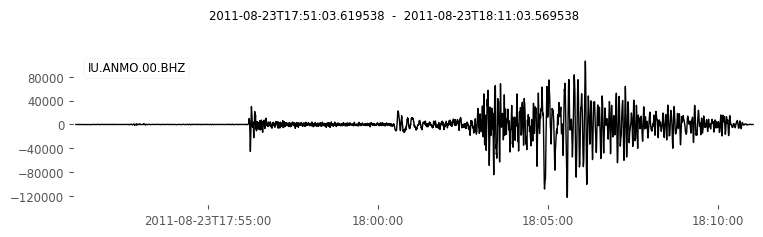

In [72]:
print("processing waveform data...")

# working copy for processing
st_w = st.copy()

# detrending & tapering
st_w.detrend("linear")
st_w.detrend("demean")
st_w.taper(max_percentage=0.05)

# plots new vertical trace
st_w[2].plot();

Converts tick count to ground displacement:

In [73]:
# obspy check, older version 1.1.1 has some issues with newer numpy version > 1.17
# checks numpy fftpack routine
print("numpy version",np.__version__)
print("obspy version",obspy.__version__)

if np.__version__ >= '1.17.0' and obspy.__version__ < '1.2.0':
    # warning
    print("")
    print("*** Please check if instrument removal works with your setup of obspy and numpy version.")
    print("*** ")
    print("*** Upgrading to obspy version 1.2.0 might be a good solution,")
    print("*** or downgrading numpy to a version < 1.17.0 can help as well.")
    print("*** ")
    print("*** In case you run into an error because of a missing fftpack() routine, you could modify the file")
    print("***   <my_python_obspy_path>/obspy/core/trace.py")
    print("***   for example")
    print("***   /opt/local/Library/Frameworks/Python.framwork/Versions/3.7/lib/python3.7/site-packages/obspy/core/trace.py")
    print("*** and replace the line:")
    print("***     #original:")
    print("***     #limit_numpy_fft_cache()")
    print("***     #daniel fix: https://github.com/obspy/obspy/issues/2434 ")
    print("***     if np.__version__ < '1.17.0': limit_numpy_fft_cache() ")
    print("*** which will work just fine.")
    print("")


numpy version 1.18.1
obspy version 1.1.1

*** Please check if instrument removal works with your setup of obspy and numpy version.
*** 
*** Upgrading to obspy version 1.2.0 might be a good solution,
*** or downgrading numpy to a version < 1.17.0 can help as well.
*** 
*** In case you run into an error because of a missing fftpack() routine, you could modify the file
***   <my_python_obspy_path>/obspy/core/trace.py
***   for example
***   /opt/local/Library/Frameworks/Python.framwork/Versions/3.7/lib/python3.7/site-packages/obspy/core/trace.py
*** and replace the line:
***     #original:
***     #limit_numpy_fft_cache()
***     #daniel fix: https://github.com/obspy/obspy/issues/2434 
***     if np.__version__ < '1.17.0': limit_numpy_fft_cache() 
*** which will work just fine.



In [74]:
# instrument response removal
# (unstable procedure)
# frequency range
f1 = 1.0/80.0  # low-frequency taper range (Hz)
f2 = 1.0/40.0  
f3 = 1.0        # high-frequency taper range (Hz)
f4 = 2.0

st_disp = st_w.copy()
st_disp.remove_response(output="DISP",pre_filt=(f1,f2,f3,f4))

print("data converted to displacement:")
print("  vertical displacement min/max = ",st_disp[2].data.min(),"/",st_disp[2].data.max(),"(m)")

data converted to displacement:
  vertical displacement min/max =  -4.76734687535e-05 / 4.76748491474e-05 (m)


# 3. Plotting

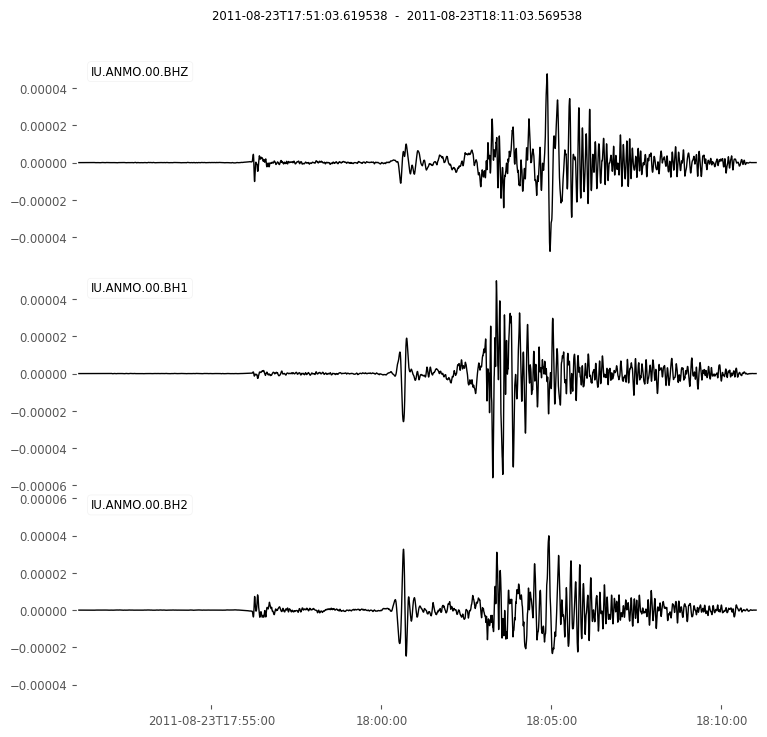

In [75]:
# plots traces
st_disp.plot();

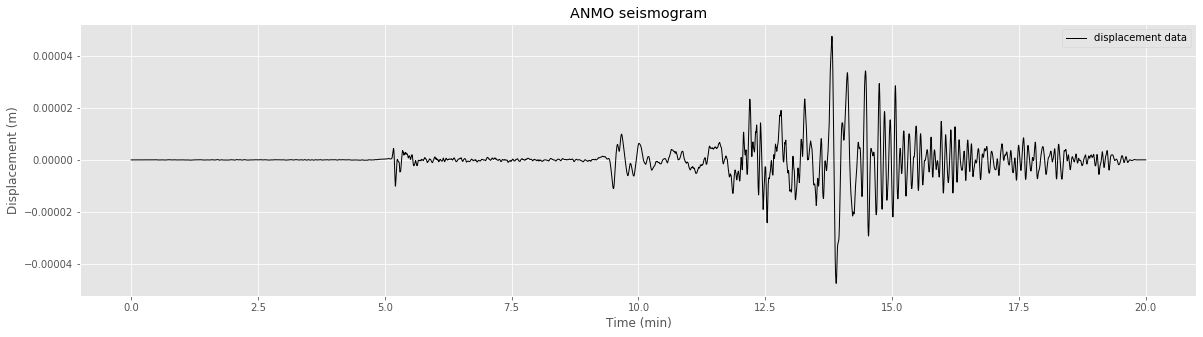

In [76]:
# vertical trace in displacement
tr1 = st_disp[2].copy()

# plotting
plt.title("ANMO seismogram")
plt.plot(t_d, tr1, color='black', linewidth=1.0,label="displacement data")
plt.legend()
plt.xlabel("Time (min)")
plt.ylabel("Displacement (m)")
plt.show()

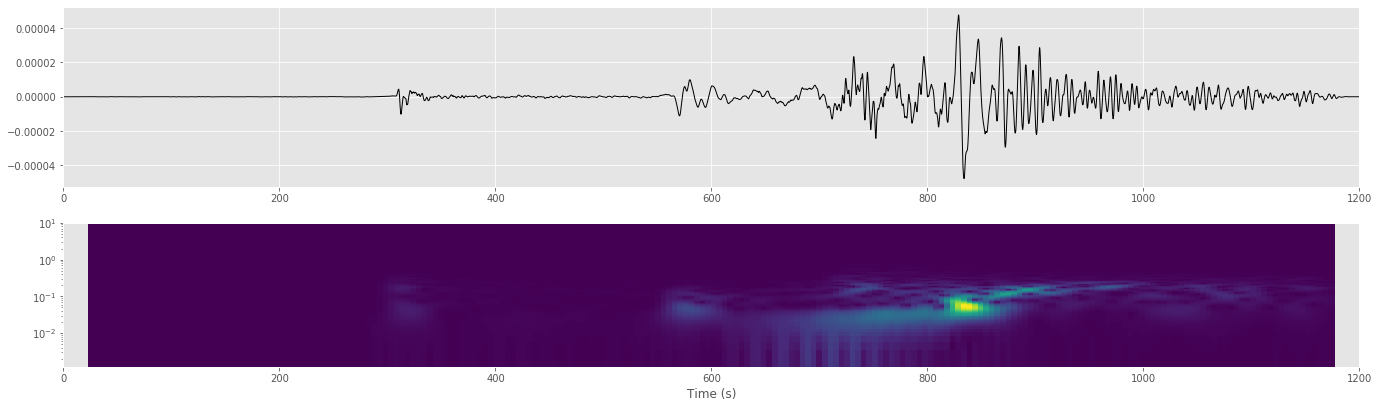

In [77]:
# spectograms
fig = plt.figure();
ax1 = fig.add_axes([0.0, 0.5, 0.9, 0.5]) #[left bottom width height]
ax2 = fig.add_axes([0.0, 0.0, 0.9, 0.4], sharex=ax1) #[left bottom width height]
ax1.set_xlim(0,1200)
# vertical trace in displacement
ax1.plot(t_d*60, st_disp[2].data, color='black', linewidth=1.0,label="ANMO data")
plt.xlabel("Time (s)")

from matplotlib.cm import get_cmap
#cmap_r = get_cmap('gist_earth_r') # inverts plt.cm.gist_earth
cmap_r = get_cmap('viridis')
st_disp[2].spectrogram(axes=ax2, log=True, wlen=40, cmap=cmap_r, show=True);


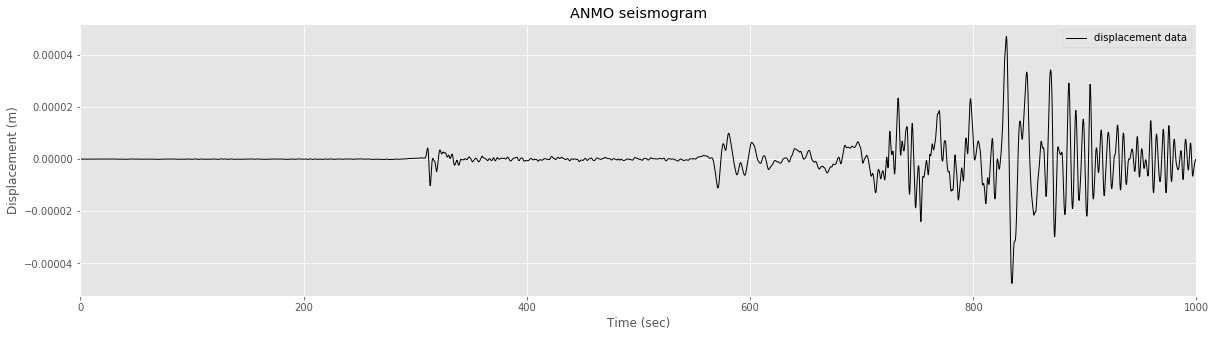

In [78]:
st_filt = st_disp.copy()
st_filt.detrend("linear")

# filters
freq0 = 1/(2.0)
st_filt.filter("lowpass", freq=freq0)

# zoom-in
t_ds = t_d * 60 # in sec

tr1 = st_filt[2].copy()

# plotting
plt.xlim(0.0, 1000.0)
# or matplotlib version >= 3.1.3
#plt.get_xaxis().set_xlim(0.0, 60.0)
plt.title("ANMO seismogram")
plt.plot(t_ds, tr1, color='black', linewidth=1.0,label="displacement data")
plt.legend()
plt.xlabel("Time (sec)")
plt.ylabel("Displacement (m)")
plt.show()


# 4. Ray paths

Plots simple ray paths for P- and S-waves.
Let's start with getting the epicentral distance from station to the event.

In [79]:
## epicentral distance
# station lat/lon
sta_lat = station.latitude
sta_lon = station.longitude
print("station lat/lon: ",sta_lat,"/",sta_lon)

# event lat/lon
lat = event.preferred_origin().latitude
lon = event.preferred_origin().longitude
print("event   lat/lon: ",lat,"/",lon)

# epicentral distance
from math import pi,sin,cos,asin,sqrt
# converts to radians
lat1_radians = lat * pi/180.0
lon1_radians = lon * pi/180.0
lat2_radians = sta_lat * pi/180.0
lon2_radians = sta_lon * pi/180.0
    
mid_lat = (lat1_radians - lat2_radians)/2.0
mid_lon = (lon1_radians - lon2_radians)/2.0
    
tmp = sqrt( pow(sin(mid_lat),2) + cos(lat1_radians)*cos(lat2_radians)*pow(sin(mid_lon),2) )
    
distance_radians = 2.0 * asin(tmp)
dist = distance_radians * 180.0/pi
print("epicentral distance :",dist,"(degree)")


station lat/lon:  34.94591 / -106.4572
event   lat/lon:  37.919 / -78.0396
epicentral distance : 22.966158221399493 (degree)


Now let calculate and plot rays using the [TauP toolkit](https://www.seis.sc.edu/taup/) calculator implemented in obspy.

In [80]:
# rays using TauP
from obspy.taup import TauPyModel
# models: prem, iasp91, ak135f
model = TauPyModel(model="prem")

# event depth
dep_km = event.preferred_origin().depth / 1000.0 # in km

print("tauP:")
print("  distance: ",dist)
print("  depth   : ",dep_km,"(km)")

# get P & S arrival times
#arrivals = model.get_travel_times(source_depth_in_km=dep_km,distance_in_degree=dist,phase_list=["P", "S"])
# all
arrivals = model.get_travel_times(source_depth_in_km=dep_km,distance_in_degree=dist)
print(arrivals) 


tauP:
  distance:  22.966158221399493
  depth   :  7.7 (km)
65 arrivals
	P phase arrival at 304.024 seconds
	P phase arrival at 304.914 seconds
	P phase arrival at 305.672 seconds
	pP phase arrival at 306.278 seconds
	pP phase arrival at 307.243 seconds
	sP phase arrival at 307.453 seconds
	pP phase arrival at 307.974 seconds
	P phase arrival at 308.109 seconds
	P phase arrival at 308.264 seconds
	sP phase arrival at 308.399 seconds
	sP phase arrival at 309.137 seconds
	pP phase arrival at 310.192 seconds
	pP phase arrival at 310.367 seconds
	sP phase arrival at 311.412 seconds
	sP phase arrival at 311.581 seconds
	P phase arrival at 317.313 seconds
	P phase arrival at 319.069 seconds
	pP phase arrival at 319.185 seconds
	sP phase arrival at 320.463 seconds
	pP phase arrival at 320.972 seconds
	sP phase arrival at 322.242 seconds
	PP phase arrival at 322.867 seconds
	PP phase arrival at 335.073 seconds
	PP phase arrival at 335.934 seconds
	PcP phase arrival at 533.492 seconds
	S phase 

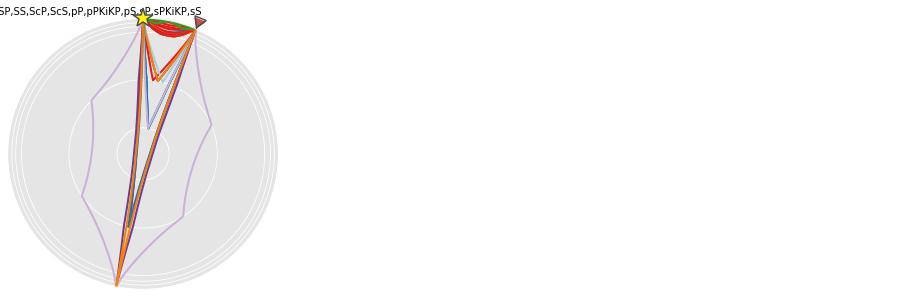

In [81]:
# plot rays
arrivals = model.get_ray_paths(source_depth_in_km=dep_km, distance_in_degree=dist)
ax = arrivals.plot_rays(plot_type="spherical",label_arrivals=True)

4 arrivals
	P phase arrival at 304.024 seconds
	S phase arrival at 557.964 seconds
	S phase arrival at 558.515 seconds
	S phase arrival at 561.486 seconds


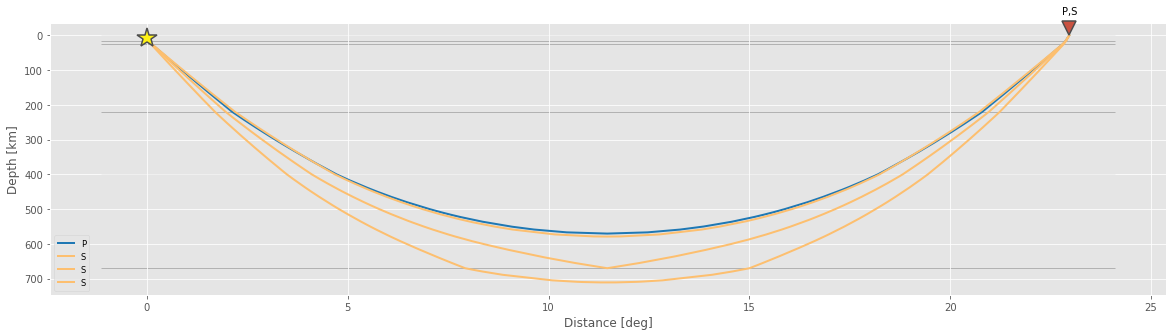

In [82]:
# since we have multiple arrivals, let's focus on the first ones
# only P-wave arrivals
arrivals_P = model.get_ray_paths(source_depth_in_km=dep_km, distance_in_degree=dist, phase_list=["P"])
#print(arrivals_P)

# only S-wave arrivals
arrivals_S = model.get_ray_paths(source_depth_in_km=dep_km, distance_in_degree=dist, phase_list=["S"])
#print(arrivals_S)

# plots only first P & S rays
arrivals = obspy.taup.tau.Arrivals([],model=model.model)
arrivals.append(arrivals_P[0])

arrivals.append(arrivals_S[0])
arrivals.append(arrivals_S[1])
arrivals.append(arrivals_S[2])



print(arrivals)
ax = arrivals.plot_rays(plot_type="cartesian",label_arrivals=True,legend=True)



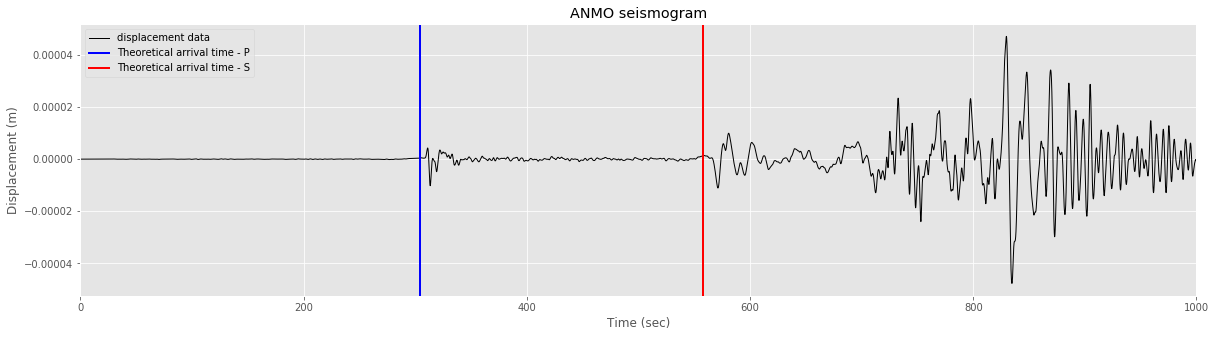

In [83]:
# use arrival times as labels in the seismogram
# travel times
t1 = arrivals_P[0].time  # in sec
t2 = arrivals_S[0].time

# plotting
plt.xlim(0.0, 1000.0)
plt.title("ANMO seismogram")
plt.plot(t_ds, tr1, color='black', linewidth=1.0,label="displacement data")
#plt.vlines(t1,-7.e6, 0, color='blue', linewidth=2.0, label="Theoretical arrival time - P") 
#plt.vlines(t2,-7.e6, 0, color='red', linewidth=2.0, label="Theoretical arrival time - S") 
plt.axvline(t1, color='blue', linewidth=2.0, label="Theoretical arrival time - P") 
plt.axvline(t2, color='red', linewidth=2.0, label="Theoretical arrival time - S") 
plt.legend()
plt.xlabel("Time (sec)")
plt.ylabel("Displacement (m)")
plt.show()


# 5. Analytical solution - Green's function

For a homogeneous medium with velocity $v$, the analytical Green's function at receiver position $x_r$ and time $t$ can be written as
$$G(x_r, t; x_s, 0) = \frac{1}{4 \pi r}\frac{1}{v^2} \delta( t - \frac{r}{v})$$
with distance $r = x_r - x_s$. 
Note that the factor $\frac{1}{v^2}$ acts as an additional amplitude term with respect to the geometrical speading $\frac{1}{4 \pi r}$. 
For slower S-wave velocities $v_s$, the amplitude thus becomes bigger compared to faster P-wave velocities $v_p$ (typically, $v_p$ > $v_s$ for rocks).

In [84]:
## setup 
# Vp velocity
vp = 8.22         # km/s
r_earth = 6371.0 # earth radius in km

# receiver distance in km
dist_km = distance_radians * r_earth
# theoretical arrival time
t_arr_vp = dist_km / vp

# Poisson solids have: vp = sqrt(3) * vs
vs = 1/sqrt(3) * vp
t_arr_vs = dist_km / vs

print("receiver distance         : ",dist_km,"(km)")
print("homogeneous Vp velocity   : ","{:2.2f}".format(vp),"(km/s)")
print("theoretical P-arrival time: ",t_arr_vp,"(s)")
print("")
print("homogeneous Vs velocity   : ","{:2.2f}".format(vs),"(km/s)")
print("theoretical S-arrival time: ",t_arr_vs,"(s)")

# time axis     
x = t_ds.copy()

# analytical Green's function
def Green_func(r,t,vel,dt=1.e-9):
    # distance r (in km), time t (in s), velocity vp (in km/s)
    from math import pi

    # zero distance case
    if abs(r) <= 1.e-9: 
        if t == 0.0:
            return 1.0
        else:
            return 0.0 
    
    # amplitude factor        
    fac = 1./(4 * pi * r) * 1.0 / vel**2

    # retarded time
    ret = t - r / vel

    # numerically t - r/vel will hardly ever be exactly zero
    if abs(ret) <= dt:
        return fac
    else:
        return 0.0

# Green's function array
# P-wave signal
G = np.zeros(len(x))
for i,t in enumerate(x):
    G[i] = Green_func(dist_km,t,vp,dt=(x[1]-x[0]))
    #if G[i] > 0: print("G = ",G[i],i,t)

# adds S-wave signal    
G_s = np.zeros(len(x))
for i,t in enumerate(x):
    G_s[i] = Green_func(dist_km,t,vs,dt=(x[1]-x[0]))
G = G + G_s
    
# source time function    
# assumes Gaussian source time function with a half-duration of the source
def Gaussian_triangle_func(x, mu, sigma):
    # Gaussian function: https://en.wikipedia.org/wiki/Gaussian_function
    #f = 1.0/(sigma * np.sqrt(2.0*np.pi)) * np.exp(-np.power((x - mu)/sigma, 2.0) / 2.0)
    # slightly modified to better match a triangle shape
    sigma_tri = sigma / 1.628
    f = 1.0/(sigma_tri * np.sqrt(2.0*np.pi)) * np.exp(-np.power((x - mu)/sigma_tri, 2.0) / 2.0)
    return f

# setting half-duration (takes it from previous example)
hdur = 1.8
print("Gaussian half-duration: ",hdur)
stf = Gaussian_triangle_func(x,0.0,hdur)

# scales by seismic moment
stf = stf * M0

# convolves Green's function with source time function
syn = np.convolve(stf, G)

# scales synthetics for plotting
syn = syn * 3.e-17

# note: in case Green's function and source time function arrays are shifted.
#       the convolution result needs to be shifted to account for the STF not starting at 0
ishift = np.argmax(x >= 0.0)  # index of first positive value (where value 0 lies)
syn = syn[ishift:len(x)+ishift]
print("min: ",syn.min(),ishift,"max: ",syn.max(),"len: ",len(syn),"len sft:",len(stf))



receiver distance         :  2553.720278735846 (km)
homogeneous Vp velocity   :  8.22 (km/s)
theoretical P-arrival time:  310.6715667561856 (s)

homogeneous Vs velocity   :  4.75 (km/s)
theoretical S-arrival time:  538.0989380887396 (s)
Gaussian half-duration:  1.8
min:  0.0 0 max:  1.19183364699e-05 len:  24000 len sft: 24000


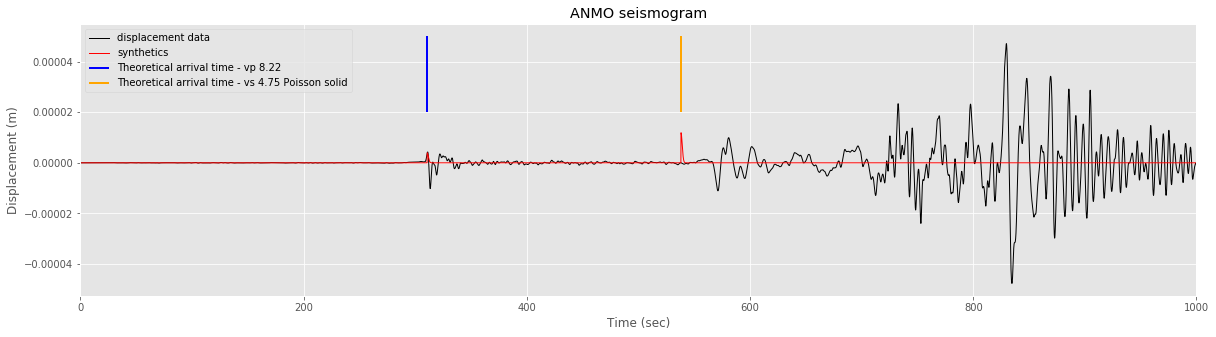

In [85]:
# plotting
plt.xlim(0.0, 1000.0)
#plt.title("synthetic seismogram")
#plt.plot(x, G, color='blue', linewidth=1.0,label="Green's function")
#plt.plot(x, stf, color='black', linewidth=1.0,label="STF")
#plt.plot(x, syn, color='red', linewidth=1.0,label="synthetics")

plt.title("ANMO seismogram")
plt.plot(t_ds, tr1, color='black', linewidth=1.0,label="displacement data")
plt.plot(x, syn, color='red', linewidth=1.0,label="synthetics")
#plt.axvline(t_arr_vp, color='blue', linewidth=2.0, label="Theoretical arrival time - vp {:2.2f}".format(vp)) 
plt.vlines(t_arr_vp,5.e-5, 2.e-5, color='blue', linewidth=2.0, label="Theoretical arrival time - vp {:2.2f}".format(vp)) 
#plt.axvline(t_arr_vs, color='orange', linewidth=2.0, label="Theoretical arrival time - vs {:2.2f} Poisson solid".format(vs)) 
plt.vlines(t_arr_vs,5.e-5, 2.e-5, color='orange', linewidth=2.0, label="Theoretical arrival time - vs {:2.2f} Poisson solid".format(vs)) 
plt.legend()
plt.xlabel("Time (sec)")
plt.ylabel("Displacement (m)")
plt.show()


# 6. PKiKP

To investigate the inner core boundary, we can focus on a very specific body wave arrival, the PKiKP phase.
Let's find a PKiKP arrival at a different station.

Compare **PKIKP** and **PKiKP** phases:
see: [Seismic phases](https://link.springer.com/referenceworkentry/10.1007%2F978-1-4020-4423-6_290)
<table>
    <tr>
    <th><img src="https://media.springernature.com/original/springer-static/image/prt%3A978-1-4020-4423-6%2F18/MediaObjects/978-1-4020-4423-6_18_Part_Fig2-290_HTML.jpg" width="500px" alt="PKIKP">
    </th>
    <th><img src="https://media.springernature.com/original/springer-static/image/prt%3A978-1-4020-4423-6%2F18/MediaObjects/978-1-4020-4423-6_18_Part_Fig4-290_HTML.jpg" width="500px" alt="PKiKP">
    </th>
    </tr>
</table>


source: lat/lon =  37.919 -78.0396


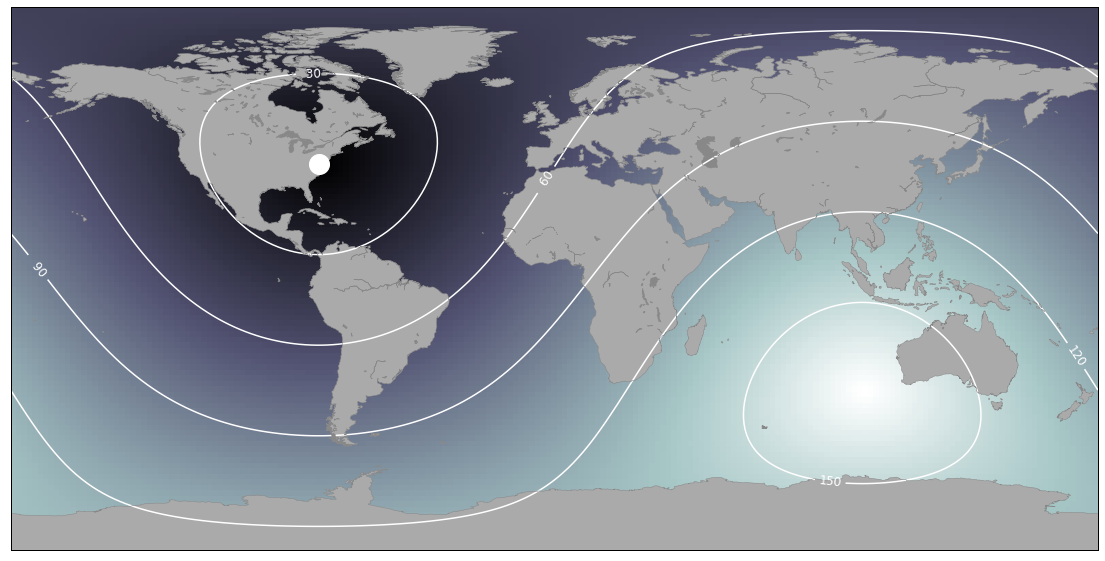

In [86]:
# event lat/lon
source_lat = event.preferred_origin().latitude
source_lon = event.preferred_origin().longitude
print("source: lat/lon = ",source_lat,source_lon)

# epicentral distance plot
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(20,10))
# Mercator: 'merc', Orthographic: 'ortho'
#m = Basemap(projection='moll',lat_0=source_lat,lon_0=source_lon,resolution='l')  
# centered at Greenwich meridian
m = Basemap(projection='cyl',lat_0=0,lon_0=0,resolution='l')  
    
# limit lon to range [-180,180]
if source_lon < -180.0: source_lon += 360.0
if source_lon > 180.0: source_lon -= 360.0

# epicentral distances to source location    
lats = np.linspace(-90, 90, num=100)
lons = np.linspace(-180, 180, num=200)    

# epicentral distance 
def epi_distance_np(lon1,lat1,source_lon=0.0,source_lat=0.0):
    # calculates epicentral distance towards source position (in degrees)
    # converts to radians
    radlon0 = np.radians(source_lon) 
    radlat0 = np.radians(source_lat)
    # for numpy arrays
    radlon1, radlat1 = map(np.radians, [lon1, lat1])
    # Haversine formula
    dlon = radlon1 - radlon0
    dlat = radlat1 - radlat0
    a = np.sin(dlat/2.0)**2 + np.cos(radlat0) * np.cos(radlat1) * np.sin(dlon/2.0)**2
    c = 2.0 * np.arcsin(np.sqrt(a))
    # converts to degrees
    epi = np.degrees(c)
    return epi

Z = epi_distance_np(source_lon=source_lon,source_lat=source_lat,*np.meshgrid(lons,lats))

# contour plot
map_x, map_y = m(*np.meshgrid(lons, lats))
cs = m.contour(map_x, map_y, Z, range(30, 360, 30), colors='white', linewidths=1.5)
plt.clabel(cs, inline=1, fmt='%3.0f', fontsize=12)
m.pcolormesh(map_x,map_y,Z, cmap=plt.cm.bone)

# coasts
m.drawcoastlines(linewidth=0.5,color='#888888')
m.drawmapboundary(fill_color='#888888')
m.fillcontinents(color='#aaaaaa')
#m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,1])
#m.drawmeridians(np.arange(-180,180,30),labels=[1,0,0,1])

# source marker
mlon, mlat = m(source_lon,source_lat)
m.plot(mlon, mlat, 'wo', markersize=20)
plt.show()


A good search tool is IRIS Wilber: <br>
[http://ds.iris.edu/wilber3/find_stations/3320897](http://ds.iris.edu/wilber3/find_stations/3320897)

Inventory created at 2020-02-27T06:25:44.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.44
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2011-08-23...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			IU
		Stations (2):
			IU.ANMO (Albuquerque, New Mexico, USA)
			IU.MAJO (Matsushiro, Japan)
		Channels (0):



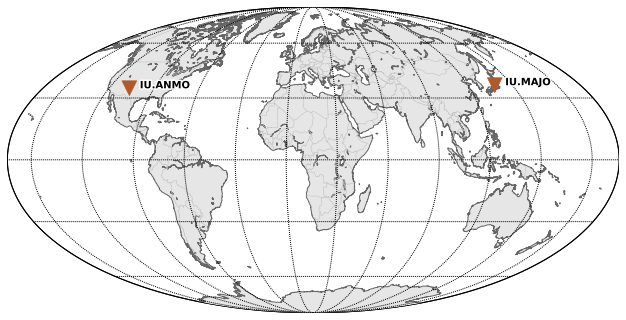

In [87]:
# gets station informations
t1 = event_time
t2 = t1 + 10 * 60

# Global network stations (naming starts with A***)
inventory = c.get_stations(network="I*", station="ANMO,MAJO",
                                starttime=t1,endtime=t2)
print(inventory)
inventory.plot();



In [88]:
# Stations ANMO and MAJO
net = "I*"
sta = "ANMO,MAJO"
cha = "BHZ"
loc = "0*" 

# time window
tshift_begin = 0 # 0 min earlier
tshift_end = 20 * 60 # 20 min after
t1 = t0 + tshift_begin             
t2 = t0 + tshift_end

# dowloads seismogram as a stream
st = c.get_waveforms(network=net, station=sta, location=loc, channel=cha,
                     starttime=t1,endtime=t2, attach_response=True)
print(st)


2 Trace(s) in Stream:
IU.ANMO.00.BHZ | 2011-08-23T17:51:03.619538Z - 2011-08-23T18:11:03.569538Z | 20.0 Hz, 24000 samples
IU.MAJO.00.BHZ | 2011-08-23T17:51:03.619538Z - 2011-08-23T18:11:03.569538Z | 20.0 Hz, 24000 samples


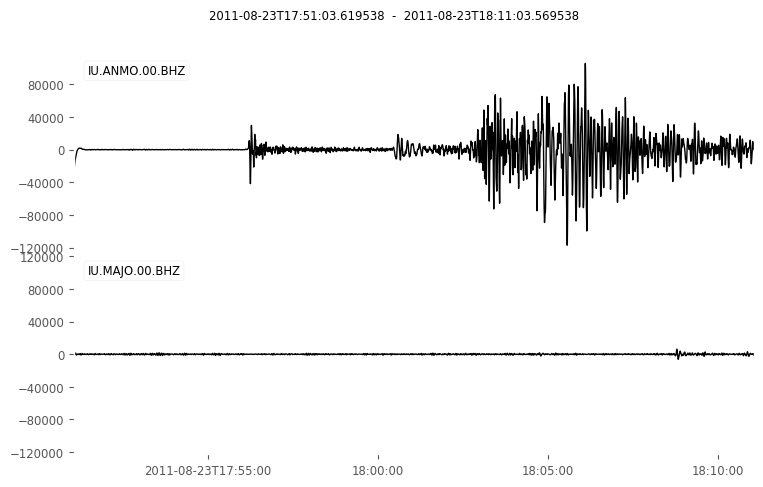

In [89]:
# compare station traces plot with some quick filtering
st_filt = st.copy()
st_filt.filter('bandpass', freqmin=0.05, freqmax=1.0, corners=2, zerophase=True)
st_filt.plot();


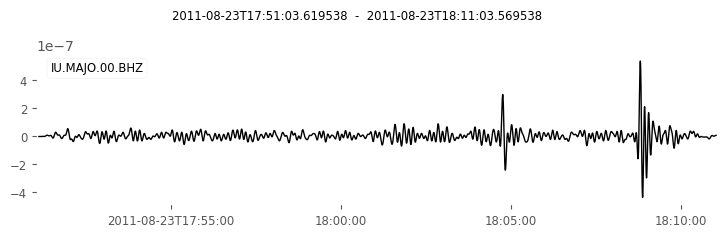

In [90]:
# instrument response removal
# (unstable procedure)
# frequency range
f1 = 1.0/80.0  # low-frequency taper range (Hz)
f2 = 1.0/60.0  
f3 = 1.0/10.0       # high-frequency taper range (Hz)
f4 = 1.0/5.0

st_disp = st.copy()
st_disp.detrend("linear")
st_disp.detrend("demean")
st_disp.taper(max_percentage=0.05)

st_disp.remove_response(output="DISP",pre_filt=(f1,f2,f3,f4))

st_disp[1].plot();

In [91]:
# MAJO is 2. station in the list
station_majo = inventory[0][1]
print(station_majo)
lat = station_majo.latitude
lon = station_majo.longitude
print("station MAJO: lat/lon = ",lat,lon)

# epicentral distance 
def epi_distance(lon1,lat1,lon2,lat2):
    # calculates epicentral distance between 2 lon/lat points (in degrees)
    # converts to radians
    radlon1 = np.radians(lon1); radlat1 = np.radians(lat1)
    radlon2 = np.radians(lon2); radlat2 = np.radians(lat2)
    # Haversine formula
    dlon = radlon2 - radlon1
    dlat = radlat2 - radlat1
    a = np.sin(dlat/2.0)**2 + np.cos(radlat1) * np.cos(radlat2) * np.sin(dlon/2.0)**2
    c = 2.0 * np.arcsin(np.sqrt(a))
    # converts to degrees
    epi = np.degrees(c)
    return epi

dist = epi_distance(source_lon,source_lat,lon,lat)
print("epicentral distance: ",dist,"(deg)")


Station MAJO (Matsushiro, Japan)
	Station Code: MAJO
	Channel Count: 0/107 (Selected/Total)
	2009-11-07T12:00:00.000000Z - 
	Access: open 
	Latitude: 36.55, Longitude: 138.20, Elevation: 405.0 m
	Available Channels:

station MAJO: lat/lon =  36.54567 138.20406
epicentral distance:  98.3490853034 (deg)


In [92]:
arrivals = model.get_travel_times(source_depth_in_km=dep_km,distance_in_degree=dist)
print(arrivals) 


31 arrivals
	P phase arrival at 816.399 seconds
	PcP phase arrival at 816.399 seconds
	pP phase arrival at 818.982 seconds
	sP phase arrival at 820.077 seconds
	PP phase arrival at 1056.126 seconds
	PKiKP phase arrival at 1088.225 seconds
	pPKiKP phase arrival at 1090.869 seconds
	sPKiKP phase arrival at 1091.950 seconds
	SKiKP phase arrival at 1303.857 seconds
	SKS phase arrival at 1454.927 seconds
	pSKS phase arrival at 1458.586 seconds
	sSKS phase arrival at 1459.686 seconds
	SKKS phase arrival at 1481.822 seconds
	S phase arrival at 1505.796 seconds
	ScS phase arrival at 1506.348 seconds
	pS phase arrival at 1509.314 seconds
	sS phase arrival at 1510.459 seconds
	SP phase arrival at 1590.016 seconds
	PS phase arrival at 1591.206 seconds
	PKKP phase arrival at 1806.581 seconds
	PKIKKIKP phase arrival at 1808.870 seconds
	SS phase arrival at 1911.025 seconds
	SKIKKIKP phase arrival at 2024.479 seconds
	PKIKKIKS phase arrival at 2025.560 seconds
	SKKP phase arrival at 2027.339 seconds

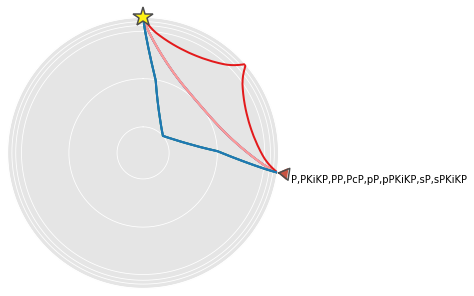

In [93]:
# plot rays
arrivals = model.get_ray_paths(source_depth_in_km=dep_km, distance_in_degree=dist,phase_list=["P","PcP","pP","sP","PP","PKiKP","pPKiKP","sPKiKP"])
ax = arrivals.plot_rays(plot_type="spherical",label_arrivals=True)


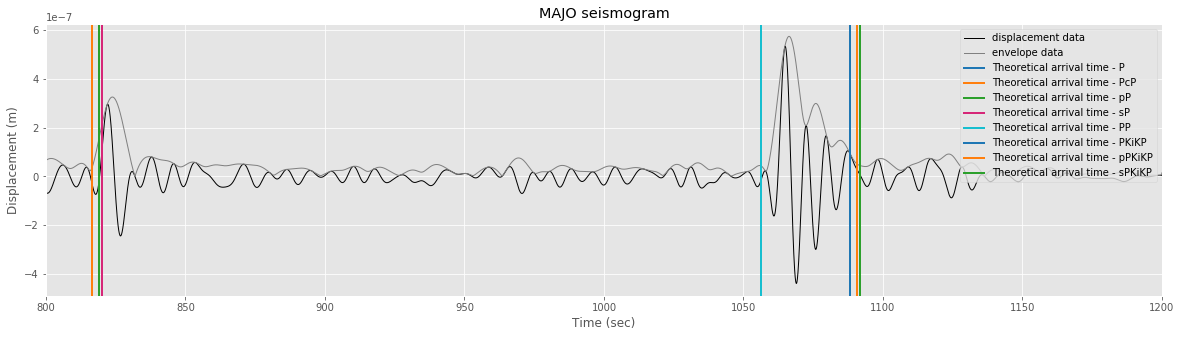

In [94]:
# majo trace
tr1 = st_disp[1].copy()

# Envelope of trace data
from obspy.signal.filter import envelope
data_envelope = envelope(tr1.data)

# plotting
plt.xlim(800.0, 1200.0)
plt.title("MAJO seismogram")
plt.plot(t_ds, tr1, color='black', linewidth=1.0,label="displacement data")
plt.plot(t_ds, data_envelope, color='gray', linewidth=1.0,label="envelope data")

# plot arrival times
for i,a in enumerate(arrivals):
    t_a = a.time
    name = a.name
    colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62778','#17becf']
    c = colors[i%5]
    plt.axvline(t_a, color=c, linewidth=2.0, label="Theoretical arrival time - {}".format(name)) 
plt.legend(loc='upper right')

plt.xlabel("Time (sec)")
plt.ylabel("Displacement (m)")
plt.show()



So, we found **P** and **PcP**, **PP** and **PKiKP**. How would you identify and separate these phases further?